# Курсовая работа по дисциплине "Технологии машинного обучения" Лисин РТ5-61Б

### Поиск и выбор набора данных для построения моделей машинного обучения

В качестве набора данных мы будем использовать набор данных Medical Cost Personal Datasets - https://www.kaggle.com/mirichoi0218/insurance

Набор данных предназначен для статистического анализа факторов, влияющих на стоимость медстраховки.

Датасет состоит из одного файла:

    insurance.csv

Файл содержит следующие колонки:

* age - возраст
* sex - пол
* bmi - индекс массы тела
* children - количество детей
* smoker - факт курения
* region - регион
* charges - медицинские расходы

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import autosklearn.regression
import sklearn.datasets
import sklearn.metrics
%matplotlib inline 
sns.set(style="ticks")

### Загрузка данных

In [2]:
data = pd.read_csv('insurance.csv', sep = ",")

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Кодирование категориальных признаков. Анализ и заполнение пропусков в данных.

### Сразу удалим дубликаты

In [3]:
data = data.drop_duplicates()

### Основные характеристики датасета

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
data.shape

(1337, 7)

In [7]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

## Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

### Удалим колонки, не представляющие пользы

In [8]:
data = data.drop('region', 1)

### Кодируем категориальные признаки

In [9]:
data = pd.get_dummies(data)

In [10]:
data.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,0,16884.92400,1,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0
2,28,33.000,3,4449.46200,0,1,1,0
3,33,22.705,0,21984.47061,0,1,1,0
4,32,28.880,0,3866.85520,0,1,1,0


In [11]:
columns = data.columns.tolist()
column = columns.pop(columns.index("charges"))
columns.append(column)

data = data[columns]

### Построение графиков, необходимых для понимания структуры данных. 

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


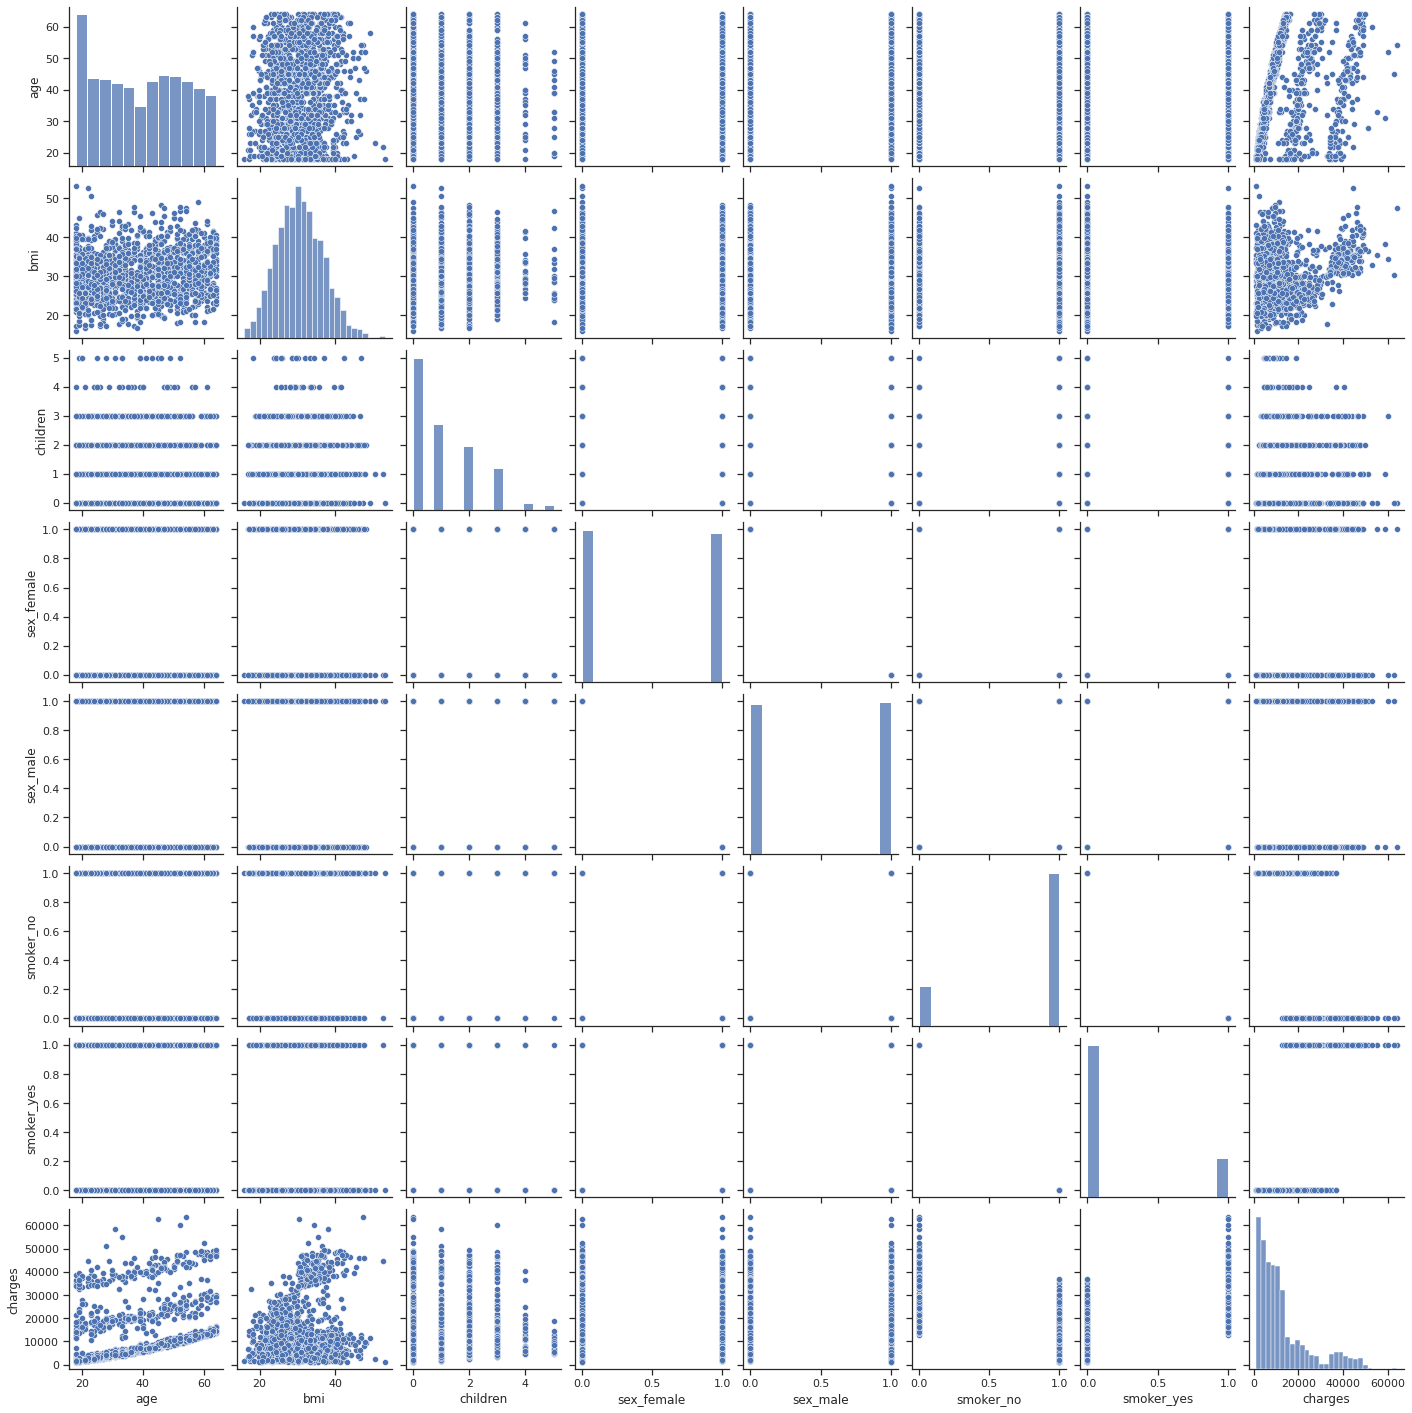

In [12]:
sns.pairplot(data)

### Выбор метрик для последующей оценки качества моделей.

В качестве метрик для решения задачи регрессии будем в основном использовать следующие метрики:
Mean squared error- средняя квадратичная ошибка

$MSE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2 $

где:

    $y$ - истинное значение целевого признака
    $\hat{y}$ - предсказанное значение целевого признака
    $N$ - размер тестовой выборки

Вычисляется с помощью функции mean_squared_error.

Метрика $R^2$ или коэффициент детерминации

$R^2(y,\hat{y}) = 1 - \frac{\sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2}{\sum\limits_{i=1}^N ( y_i - \overline{y_i} )^2} $

где:

    $y$ - истинное значение целевого признака
    $\hat{y}$ - предсказанное значение целевого признака
    $N$ - размер тестовой выборки
    $\overline{y_i} = \frac{1}{N} \cdot \sum\limits_{i=1}^N y_i $

Вычисляется с помощью функции r2_score.

Коэффициент детерминации для модели с константой принимает значения от 0 до 1. Чем ближе значение коэффициента к 1, тем сильнее зависимость. При оценке регрессионных моделей это интерпретируется как соответствие модели данным. Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 50 % (в этом случае коэффициент множественной корреляции превышает по модулю 70 %). Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими (коэффициент корреляции превышает 90 %). Значение коэффициента детерминации 1 означает функциональную зависимость между переменными.

Основная проблема применения (выборочного) R2
заключается в том, что его значение увеличивается (не уменьшается) от добавления в модель новых переменных, даже если эти переменные никакого отношения к объясняемой переменной не имеют! Поэтому сравнение моделей с разным количеством факторов с помощью коэффициента детерминации, вообще говоря, некорректно. Для этих целей можно использовать альтернативные показатели.

### Корреляционная карта

<AxesSubplot:>

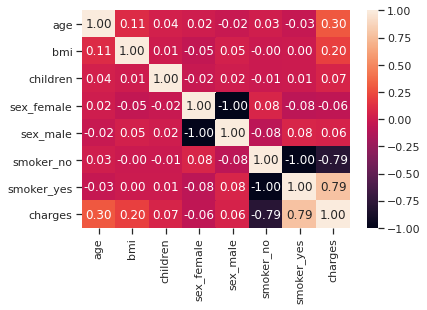

In [13]:
sns.heatmap(data.corr(), annot = True, fmt = '.2f')

## Масштабирование данных.

### Изучим данные

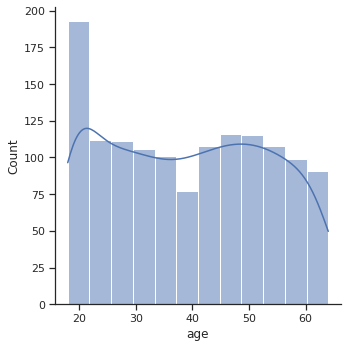

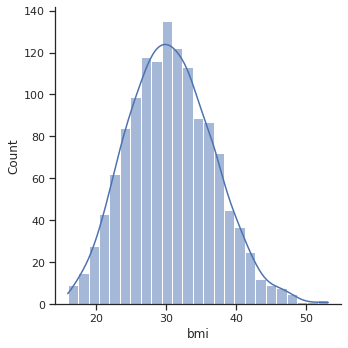

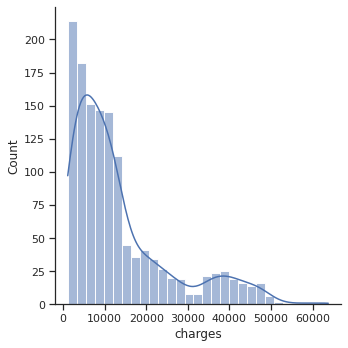

In [14]:
sns.displot(data=data, x="age", kde = True)
sns.displot(data=data, x="bmi", kde = True)
sns.displot(data=data, x="charges", kde = True)

### Используем минмакс стратегию масштабирования, так как распределение похоже на нормальное

In [15]:
mms = MinMaxScaler()
temp = mms.fit_transform(data[['age']])
data["age"] = temp
temp = mms.fit_transform(data[['bmi']])
data["bmi"] = temp
temp = mms.fit_transform(data[['charges']])
data["charges"] = temp

### Вот как выглядит набор данных после масштабирования

In [16]:
data.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,charges
0,0.021739,0.321227,0,1,0,0,1,0.251611
1,0.000000,0.479150,1,0,1,1,0,0.009636
2,0.217391,0.458434,3,0,1,1,0,0.053115
3,0.326087,0.181464,0,0,1,1,0,0.333010
4,0.304348,0.347592,0,0,1,1,0,0.043816


### Разделение выборки на обучающую и тестовую

In [17]:
y_column = "charges"
x_columns = data.columns.tolist()
x_columns.pop(x_columns.index(y_column))

data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(data[x_columns], data[y_column], test_size = 0.9, random_state = 15)

## K ближайших соседей

## Построение базового решения (baseline) без подбора гиперпараметров.

In [50]:
knn = KNeighborsRegressor(n_neighbors = 15)

knn.fit(data_x_train, data_y_train)

knn_prediction = knn.predict(data_x_test)

In [51]:
print('Средняя абсолютная ошибка:',   mean_absolute_error(data_y_test, knn_prediction))
print('Медианная абсолютная ошибка:',   median_absolute_error(data_y_test, knn_prediction))
print('Среднеквадратичная ошибка:',   mean_squared_error(data_y_test, knn_prediction, squared = False))
print('Коэффициент детерминации:',   r2_score(data_y_test, knn_prediction))

Средняя абсолютная ошибка: 0.08178457187518767
Медианная абсолютная ошибка: 0.05203508925802404
Среднеквадратичная ошибка: 0.12091795696307428
Коэффициент детерминации: 0.6060122440295148


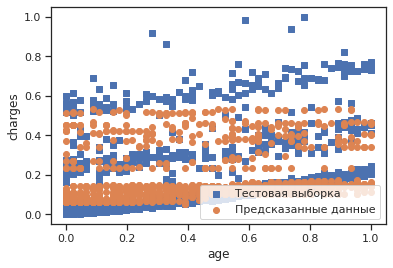

In [52]:
plt.scatter(data_x_test.age, data_y_test,    marker = 's', label = 'Тестовая выборка')
plt.scatter(data_x_test.age, knn_prediction, marker = 'o', label = 'Предсказанные данные')
plt.legend (loc = 'lower right')
plt.xlabel ('age')
plt.ylabel ('charges')
plt.show()

## Подбор гиперпараметров

In [54]:
n_range = np.array(range(1, 51, 1))
tuned_parameters = [{'n_neighbors': n_range}]
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=10, scoring='neg_mean_squared_error')
gs.fit(data_x_train, data_y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])}],
             scoring='neg_mean_squared_error')

In [55]:
print('Лучшая модель:', gs.best_estimator_)
print('\nЛучшее число ближайших соседей:',gs.best_params_) 
print('\nЛучшее значение средней квадратичной ошибки:',gs.best_score_)

Лучшая модель: KNeighborsRegressor(n_neighbors=6)

Лучшее число ближайших соседей: {'n_neighbors': 6}

Лучшее значение средней квадратичной ошибки: -0.009533415104549511


Изменение качества тестовой выборки в зависимости от кол-ва соседей:



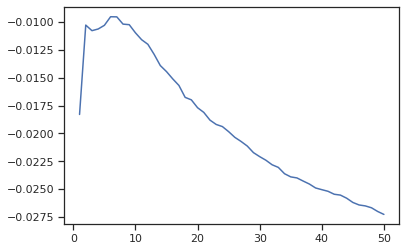

In [56]:
print('Изменение качества тестовой выборки в зависимости от кол-ва соседей:\n') 
plt.plot(n_range, gs.cv_results_['mean_test_score'])

Лучшая модель: KNeighborsRegressor(n_neighbors=2)

Лучшее число ближайших соседей: {'n_neighbors': 2}

Лучшее значение коэффициента детерминации: 0.666743331409234

Изменение качества тестовой выборки в зависимости от кол-ва соседей:



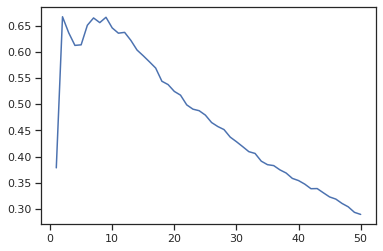

In [58]:
gs_det = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=10, scoring='r2') 
gs_det.fit(data_x_train, data_y_train)
print('Лучшая модель:', gs_det.best_estimator_)
print('\nЛучшее число ближайших соседей:',gs_det.best_params_)
print('\nЛучшее значение коэффициента детерминации:',gs_det.best_score_)
print('\nИзменение качества тестовой выборки в зависимости от кол-ва соседей:\n') 
plt.plot(n_range, gs_det.cv_results_['mean_test_score'])

## Линейная регрессия

In [59]:
Lin_Reg = LinearRegression().fit(data_x_train, data_y_train)

lr_y_pred = Lin_Reg.predict(data_x_test)

In [60]:
print('Средняя абсолютная ошибка:',   mean_absolute_error(data_y_test, lr_y_pred))
print('Медианная абсолютная ошибка:',   median_absolute_error(data_y_test, lr_y_pred))
print('Среднеквадратичная ошибка:',   mean_squared_error(data_y_test, lr_y_pred, squared = False))
print('Коэффициент детерминации:',   r2_score(data_y_test, lr_y_pred))

Средняя абсолютная ошибка: 0.0785696696179368
Медианная абсолютная ошибка: 0.05989478522585989
Среднеквадратичная ошибка: 0.10524398581296852
Коэффициент детерминации: 0.7015334272041599


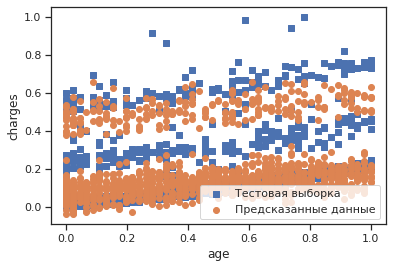

In [63]:
plt.scatter(data_x_test.age, data_y_test,    marker = 's', label = 'Тестовая выборка')
plt.scatter(data_x_test.age, lr_y_pred, marker = 'o', label = 'Предсказанные данные')
plt.legend (loc = 'lower right')
plt.xlabel ('age')
plt.ylabel ('charges')
plt.show()

## SVM

In [67]:
SV = SVR()
SV.fit(data_x_train, data_y_train)
sv_y_pred = SV.predict(data_x_test)

In [68]:
print('Средняя абсолютная ошибка:',   mean_absolute_error(data_y_test, sv_y_pred))
print('Медианная абсолютная ошибка:',   median_absolute_error(data_y_test, sv_y_pred))
print('Среднеквадратичная ошибка:',   mean_squared_error(data_y_test, sv_y_pred, squared = False))
print('Коэффициент детерминации:',   r2_score(data_y_test, sv_y_pred))

Средняя абсолютная ошибка: 0.09646928919374483
Медианная абсолютная ошибка: 0.09040794623991173
Среднеквадратичная ошибка: 0.11195337856034442
Коэффициент детерминации: 0.6622654174874918


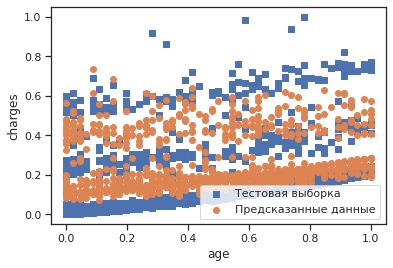

In [69]:
plt.scatter(data_x_test.age, data_y_test,    marker = 's', label = 'Тестовая выборка')
plt.scatter(data_x_test.age, sv_y_pred, marker = 'o', label = 'Предсказанные данные')
plt.legend (loc = 'lower right')
plt.xlabel ('age')
plt.ylabel ('charges')
plt.show()

## Случайный лес

## Построение базового решения (baseline) без подбора гиперпараметров.

In [18]:
forest = RandomForestRegressor(n_estimators=15, oob_score=True, random_state=10)
forest.fit(data_x_train, data_y_train)

/home/foxers/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(n_estimators=15, oob_score=True, random_state=10)

In [19]:
rf_y_pred = forest.predict(data_x_test)

In [20]:
print('Средняя абсолютная ошибка:',   mean_absolute_error(data_y_test, rf_y_pred))
print('Медианная абсолютная ошибка:',   median_absolute_error(data_y_test, rf_y_pred))
print('Среднеквадратичная ошибка:',   mean_squared_error(data_y_test, rf_y_pred, squared = False))
print('Коэффициент детерминации:',   r2_score(data_y_test, rf_y_pred))

Средняя абсолютная ошибка: 0.04367485916358048
Медианная абсолютная ошибка: 0.01594711656466677
Среднеквадратичная ошибка: 0.07945494223052879
Коэффициент детерминации: 0.8298848641022152


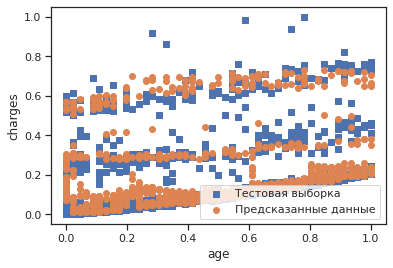

In [21]:
plt.scatter(data_x_test.age, data_y_test,    marker = 's', label = 'Тестовая выборка')
plt.scatter(data_x_test.age, rf_y_pred, marker = 'o', label = 'Предсказанные данные')
plt.legend (loc = 'lower right')
plt.xlabel ('age')
plt.ylabel ('charges')
plt.show()

## Подбор гиперпараметров

In [22]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = {'n_estimators': np.array(range(1, 101, 1)), 'max_depth': [None, 1, 2, 3], 'min_samples_split': [1, 2, 3]}
gs = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
gs.fit(data_x_train, data_y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


/home/foxers/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -0.00581019 -0.00577088
 -0.00576855]
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])},
             scoring='neg_mean_squared_error', verbose=1)

In [23]:
print('Лучшая модель:', gs.best_estimator_)
print('\nЛучшие параметры:',gs.best_params_) 
print('\nЛучшее значение средней квадратичной ошибки:',gs.best_score_)

Лучшая модель: RandomForestRegressor(max_depth=2, n_estimators=6)

Лучшие параметры: {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 6}

Лучшее значение средней квадратичной ошибки: -0.005093472939053056


In [24]:
tuned_parameters = {'n_estimators': np.array(range(1, 101, 1)), 'max_depth': [None, 1, 2, 3], 'min_samples_split': [1, 2, 3]}

gs_det = GridSearchCV(ensemble.RandomForestRegressor(), tuned_parameters, cv=5, n_jobs=-1, verbose=1, scoring='r2')
gs_det.fit(data_x_train, data_y_train)
print('Лучшая модель:', gs_det.best_estimator_)
print('\nЛучшие параметры:',gs_det.best_params_)
print('\nЛучшее значение коэффициента детерминации:',gs_det.best_score_)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Лучшая модель: RandomForestRegressor(max_depth=2, min_samples_split=3, n_estimators=1)

Лучшие параметры: {'max_depth': 2, 'min_samples_split': 3, 'n_estimators': 1}

Лучшее значение коэффициента детерминации: 0.8495457081066023


/home/foxers/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.82897621 0.8318235  0.8257176 ]
  warnings.warn(


Как мы видим результаты с подобранными гиперпараметрами по коэффиценту детерминации близки, а по значению средне квадратичной ошибки гораздо лучше.

## Бэггинг

## Построение базового решения (baseline) без подбора гиперпараметров.

In [25]:
bagging = BaggingRegressor(n_estimators=31, oob_score=True, random_state=10)
bagging.fit(data_x_train, data_y_train)

BaggingRegressor(n_estimators=31, oob_score=True, random_state=10)

In [26]:
bg_y_pred = bagging.predict(data_x_test)

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,  median_absolute_error, r2_score

print('Средняя абсолютная ошибка:',   mean_absolute_error(data_y_test, bg_y_pred))
print('Медианная абсолютная ошибка:',   median_absolute_error(data_y_test, bg_y_pred))
print('Среднеквадратичная ошибка:',   mean_squared_error(data_y_test, bg_y_pred, squared = False))
print('Коэффициент детерминации:',   r2_score(data_y_test, bg_y_pred))

Средняя абсолютная ошибка: 0.04507768933335717
Медианная абсолютная ошибка: 0.01685838073078169
Среднеквадратичная ошибка: 0.08052901537181663
Коэффициент детерминации: 0.8252545397257531


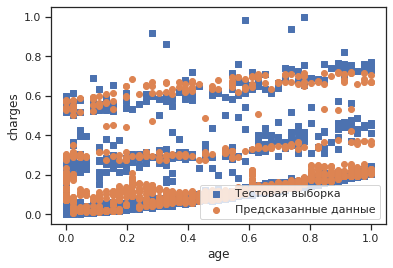

In [28]:
plt.scatter(data_x_test.age, data_y_test,    marker = 's', label = 'Тестовая выборка')
plt.scatter(data_x_test.age, bg_y_pred, marker = 'o', label = 'Предсказанные данные')
plt.legend (loc = 'lower right')
plt.xlabel ('age')
plt.ylabel ('charges')
plt.show()

## Подбор гиперпараметров

In [29]:
tuned_parameters = {'n_estimators': np.array(range(1, 101, 1)), 'oob_score':[True], 'random_state':[10]}

clf = GridSearchCV(ensemble.BaggingRegressor(), tuned_parameters, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
clf.fit(data_x_train, data_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/foxers/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:1069: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=5, estimator=BaggingRegressor(), n_jobs=-1,
             param_grid={'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100]),
                         'oob_score': [True], 'random_state': [10]},
             scoring='neg_mean_squared_error', verbose=1)

In [30]:
print('Лучшая модель:', clf.best_estimator_)
print('\nЛучшее число:',clf.best_params_)
print('\nЛучшее значение средней квадратичной ошибки:',clf.best_score_)

Лучшая модель: BaggingRegressor(n_estimators=19, oob_score=True, random_state=10)

Лучшее число: {'n_estimators': 19, 'oob_score': True, 'random_state': 10}

Лучшее значение средней квадратичной ошибки: -0.0065594751931988965


In [31]:
clf = GridSearchCV(ensemble.BaggingRegressor(), tuned_parameters, cv=5, n_jobs=-1, verbose=1, scoring='r2')
clf.fit(data_x_train, data_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/foxers/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:1069: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=5, estimator=BaggingRegressor(), n_jobs=-1,
             param_grid={'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100]),
                         'oob_score': [True], 'random_state': [10]},
             scoring='r2', verbose=1)

In [32]:
print('Лучшая модель:', clf.best_estimator_)
print('\nЛучшее число:',clf.best_params_)
print('\nЛучшее значение коэффициента детерминации:',clf.best_score_)

Лучшая модель: BaggingRegressor(n_estimators=19, oob_score=True, random_state=10)

Лучшее число: {'n_estimators': 19, 'oob_score': True, 'random_state': 10}

Лучшее значение коэффициента детерминации: 0.8036474825343938


Как мы видим результаты с подобранными гиперпараметрами по значению средне квадратичной ошибки немного лучше.

## Вывод

По итогу случайный лес показал себя лучше чем Бэггинг(Возможно потому что случайный лес как таковой это и есть бэггинг над решающими деревьями)

# AutoML

In [41]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=700,
    per_run_time_limit=100,
    tmp_folder='/tmp/autosklearn_regression_example_tmp7',
    output_folder='/tmp/autosklearn_regression_example_out7',
)
automl.fit(data_x_train, data_y_train, dataset_name='Estate')

AutoSklearnRegressor(output_folder='/tmp/autosklearn_regression_example_out7',
                     per_run_time_limit=100, time_left_for_this_task=700,
                     tmp_folder='/tmp/autosklearn_regression_example_tmp7')

In [42]:
print(automl.show_models())

[(1.000000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.01, 'regressor:random_forest:bootstrap': 'True', 'regressor:random_forest:criterion': 'mse', 'regressor:random_forest:max_depth': 'None', 'regressor:random_forest:max_features': 1.0, 'regressor:random_forest:max_leaf_nodes': 'None', 'regressor:random_forest:min_impurity_decrease': 0.0, 'regressor:random_forest:min_samples_leaf': 1, 'regressor:random_forest:min_samples_split': 2, 'regressor:random_forest:min_

In [43]:
predictions = automl.predict(data_x_test)
print("Коэффицент детерминации:", sklearn.metrics.r2_score(data_y_test, predictions))

Коэффицент детерминации: 0.8237805557344458


In [44]:
print("Среднеквадратичная ошибка:", sklearn.metrics.mean_squared_error(data_y_test, predictions))

Среднеквадратичная ошибка: 0.0065396228604179965


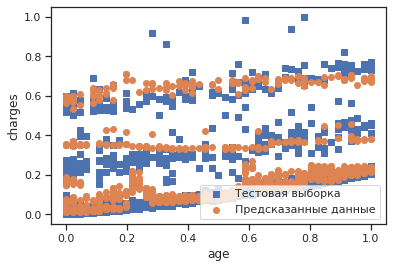

In [45]:
plt.scatter(data_x_test.age, data_y_test,    marker = 's', label = 'Тестовая выборка')
plt.scatter(data_x_test.age, predictions, marker = 'o', label = 'Предсказанные данные')
plt.legend (loc = 'lower right')
plt.xlabel ('age')
plt.ylabel ('charges')
plt.show()

Результаты по значению средне квадратичной ошибки немного хуже чем рандомный лес вручную и немного хуже чем бэггинг, по значению среднеквадратичной ошибки хуже чем лучший результат обеих моделей